<a href="https://colab.research.google.com/github/d22cs051/dlops-23/blob/main/assignment/D22CS051_Lab_Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab Assignment 3: Optimizers

## Checking Avilable GPU

In [ ]:
!nvidia-smi

Sun Feb 26 22:45:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.78.01    Driver Version: 525.78.01    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
|  0%   53C    P8    32W / 350W |    182MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Importing requirements

In [ ]:
# pytorch libs
import torch
from torch import nn
import torchvision

# matplot libs
import matplotlib.pyplot as plt

# numpy
import numpy as np

# torch metrics
try:
  import torchmetrics
except:
  !pip3 -q install torchmetrics
import torchmetrics
from torchmetrics.classification import Accuracy

try:
  import torchinfo
except:
  !pip3 -q install torchinfo
finally:
  from torchinfo import summary

try:
  import torchattacks
except:
  !pip3 -q install torchattacks
finally:
  import torchattacks

## device agnostic code

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Model Defination

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights
# Model with pretrained weights Architecture - Resnet18resnet18

weights_resnet = ResNet18_Weights.DEFAULT # best avilable weights for the model
model_resnet = resnet18(weights=weights_resnet)
auto_transform_resnet = weights_resnet.transforms() # best avilable transforms for the model

model_resnet, auto_transform_resnet

(ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
     (1): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU

In [ ]:
# freeze all the layers resnet
for param in model_resnet.parameters():
    param.requires_grad = False
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, 10).to(device) # 10 classes in STL

## Model summary

In [ ]:
summary(model=model_resnet,
        input_size=(32,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"],
        )

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 10]             --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (36,864)             False
│    │    

## Getting Dataset with pytorch

### Downloading Dataset

In [ ]:
from torchvision import transforms


train_dataset = torchvision.datasets.STL10(
    root='data',
    split='train',
    download=True,
    transform=auto_transform_resnet,
)

test_dataset = torchvision.datasets.STL10(
    root='data',
    split='test',
    download=True,
    transform=auto_transform_resnet,
)
train_dataset, test_dataset


Files already downloaded and verified
Files already downloaded and verified


(Dataset STL10
     Number of datapoints: 5000
     Root location: data
     Split: train
     StandardTransform
 Transform: ImageClassification(
                crop_size=[224]
                resize_size=[256]
                mean=[0.485, 0.456, 0.406]
                std=[0.229, 0.224, 0.225]
                interpolation=InterpolationMode.BILINEAR
            ),
 Dataset STL10
     Number of datapoints: 8000
     Root location: data
     Split: test
     StandardTransform
 Transform: ImageClassification(
                crop_size=[224]
                resize_size=[256]
                mean=[0.485, 0.456, 0.406]
                std=[0.229, 0.224, 0.225]
                interpolation=InterpolationMode.BILINEAR
            ))

### Vis. dataset (train dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


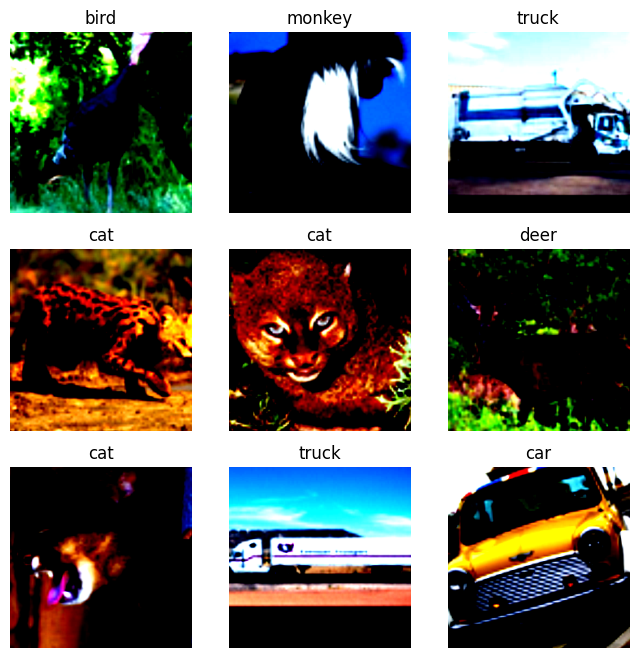

In [ ]:
# randomly ploting image samples from the grayscale dataset
classes = train_dataset.classes
labels_map = {classes[i]:i for i in range(10)}  # getting class -> index map
labels_map = dict(map(reversed, labels_map.items()))  # inverting dict
# print(labels_map)

figure = plt.figure(figsize=(8, 8))  # fixing plotsize
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(
        len(train_dataset), size=(1,)
    )  # randomely selecting one image sample from the image index
    img, label = train_dataset[sample_idx]  # getting image and label of selected index
    # sub plot code
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(
        img.permute(1, 2, 0)
    )  # NOTE:- Color map is gray because we're converting imgae to grayscale / changing channel to HWC for color image
    # sub plot code ends
plt.show()
# NOTE: WARRING BECAUSE OF auto_transforms

### Converting dataset to dataloader

In [ ]:
import os

# hyper parms. for dataloader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()  # no. of avilable cpu cores

# train dataloader
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS
)

# test dataloader
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)

print(f"Numbers of Batches in Train Dataloader: {len(train_dataloader)}")
print(f"Numbers of Batches in Test Dataloader: {len(test_dataloader)}")
# train_dataloader,test_dataloader

Numbers of Batches in Train Dataloader: 157
Numbers of Batches in Test Dataloader: 250


## Models Training

### Plot loss curves of a model

In [ ]:
# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()

### making training, testing steps, train model functions

#### set seeds function

In [ ]:
### set seed function
def set_seed(seed: int = 42):
    """
    sets mannual seeds for both cpu and cuda
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)


#### train step

In [ ]:
def training_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    optimizer: torch.optim.Optimizer,
    device: str,
):
    """
    Desc:
      funtion to perform traning step for one EPOCH

    Args:
      model (nn.Module): Pytorch model class object
      dataloader (torch.utils.data.DataLoader): training dataloder from training dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      optimizer (torch.optim.Optimizer): Optimizer Function (object) of your choice
      device (str): Torch Device "CPU/GPU"
    Returns:
      train_loss (float), train_acc (float): training loss and training accuracy for one EPOCH
    """
    model.train()  # putting model in traing model

    train_loss, train_acc = 0, 0  # initlizing loss and acc. for the epoch

    # print(type(model.parameters()))
    for (X, y) in dataloader:  # loop in batches
        # model_parms_before_forward_pass = np.array([x.detach().numpy() for x in model.parameters()].copy())
        X, y = X.to(device), y.to(device)  # sending the data to target device
        # print(f"shape of X: {X.shape}, shape of y: {y.shape}")
        
        # 1. forward pass
        y_pred_logits = model(X)
        # y_pred = y_pred_logits.argmax(dim=1).type(torch.int)
        # print(y_pred)
        # 2. calculate the loss
        loss = loss_fn(y_pred_logits, y)
        train_loss += loss.item()

        # 3. optimizer zero grad
        optimizer.zero_grad()

        # 4. loss backword
        loss.backward()

        # 5. optimizer step
        optimizer.step()

        # model_parms_after_forward_pass = np.array([x.detach().numpy() for x in model.parameters()])
        # print("Model parms diff:")
        # print([(i,j) for (i,j) in zip(iter(model_parms_after_forward_pass),iter(model_parms_before_forward_pass))])
        # print(model_parms_after_forward_pass - model_parms_before_forward_pass,sep="\n")
        train_acc += acc_fn(y_pred_logits, y).item()

    # 6. returning actual loss and acc.x
    return train_loss / len(dataloader), train_acc / len(dataloader)


#### test step

In [ ]:
def testing_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    device: str,
):
    """
    Desc:
      funtion to perform testing step for one EPOCH

    Args:
      model (nn.Module): Pytorch model class object
      dataloader (torch.utils.data.DataLoader): testing dataloder from training dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      device (str): Torch Device "CPU/GPU"
    Returns:
      test_loss (float), test_acc (float): testing loss and testing accuracy for one EPOCH
    """
    model.eval()  # putting model in eval model

    test_loss, test_acc = 0, 0  # initlizing loss and acc. for the epoch

    # with torch.inference_mode(): # disabling inference mode for aqcuiring gradients of perturbed data
    for (X, y) in dataloader:  # loop in batches
        X, y = X.to(device), y.to(device)  # sending the data to target device
        # print(f"shape of X: {X.shape}, shape of y: {y.shape}")

        # 1. forward pass
        y_pred_logits = model(X)

        # 2. calculate the loss
        loss = loss_fn(y_pred_logits, y)
        test_loss += loss.item()

        # printing the prediction and actual label
        # print(y_pred_logits.argmax(dim=1), y,sep='\n')
        
        # 3. calculating accuracy
        test_acc += acc_fn(y_pred_logits, y).item()

    # 6. returning actual loss and acc.
    return test_loss / len(dataloader), test_acc / len(dataloader)

#### training function

In [ ]:
from tqdm.auto import tqdm


def train(
    model: nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    optimizer: torch.optim.Optimizer,
    epochs: int
):
    """
    Desc:
      funtion to perform training for one {epochs} param

    Args:
      model (nn.Module): Pytorch model class object
      train_dataloader (torch.utils.data.DataLoader): training dataloder from training dataset
      test_dataloader (torch.utils.data.DataLoader): testing dataloder from testing dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      device (str): Torch Device "CPU/GPU"
      epochs (int): number of epochs to train the model
    Returns:
      result_dict ({str: List[float]}): testing loss and testing accuracy for one EPOCH
    """
    # 1. init. result dict
    result_dict = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    # 2. loop in range epochs performs train and test steps on the model
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = training_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            acc_fn=acc_fn,
            optimizer=optimizer,
            device=device,
        )

        test_loss, test_acc = testing_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            acc_fn=acc_fn,
            device=device,
        )

        # 3. print out results
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 4. adding results to result_dict
        result_dict["train_loss"].append(train_loss)
        result_dict["train_acc"].append(train_acc)
        result_dict["test_loss"].append(test_loss)
        result_dict["test_acc"].append(test_acc)

    # 5. return result dict
    return result_dict


### train loop for model_resnet training with different optimizers

#### USING Optimizer Adam

In [ ]:
# Hyperparms
lr = [1e-3,1e-4] # learning rate
betas=[(0.8, 0.888),(0.9, 0.999)] # coefficients used for computing running averages of gradient and its square
eps = [1e-8] # term added to the denominator to improve numerical stability
weight_decay = [1e-3] # weight decay (L2 penalty)

parms_combs = [(l,b,e,w_d) for l in lr for b in betas for e in eps for w_d in weight_decay]
# print(parms_combs)

# init. epochs
NUM_EPOCHS = 10

# init. loss function, accuracy function and optimizer
loss_fn = nn.CrossEntropyLoss()
acc_fn = Accuracy(task="multiclass", num_classes=10, top_k=5).to(device=device)


current exp / total: 1 / 4
NOTE:- The Accuracy is Top-5 Not Top-1 !!!
Training with: lr: 0.001, betas: (0.8, 0.888), eps: 1e-08, weight_decay: 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7375 | train_acc: 0.9709 | test_loss: 0.2930 | test_acc: 0.9981
Epoch: 2 | train_loss: 0.2733 | train_acc: 0.9972 | test_loss: 0.2058 | test_acc: 0.9985
Epoch: 3 | train_loss: 0.2159 | train_acc: 0.9982 | test_loss: 0.1866 | test_acc: 0.9985
Epoch: 4 | train_loss: 0.1861 | train_acc: 0.9978 | test_loss: 0.1844 | test_acc: 0.9988
Epoch: 5 | train_loss: 0.1746 | train_acc: 0.9986 | test_loss: 0.1709 | test_acc: 0.9986
Epoch: 6 | train_loss: 0.1635 | train_acc: 0.9990 | test_loss: 0.1878 | test_acc: 0.9984
Epoch: 7 | train_loss: 0.1489 | train_acc: 0.9992 | test_loss: 0.1784 | test_acc: 0.9985
Epoch: 8 | train_loss: 0.1437 | train_acc: 0.9994 | test_loss: 0.1665 | test_acc: 0.9988
Epoch: 9 | train_loss: 0.1302 | train_acc: 0.9996 | test_loss: 0.1988 | test_acc: 0.9974
Epoch: 10 | train_loss: 0.1292 | train_acc: 0.9992 | test_loss: 0.1744 | test_acc: 0.9985
total training time: 110.868 sec.
LOSS & Accuracy Curves
lr: 0.001, betas: (0.8, 0.888), eps: 1e-08, weight_d

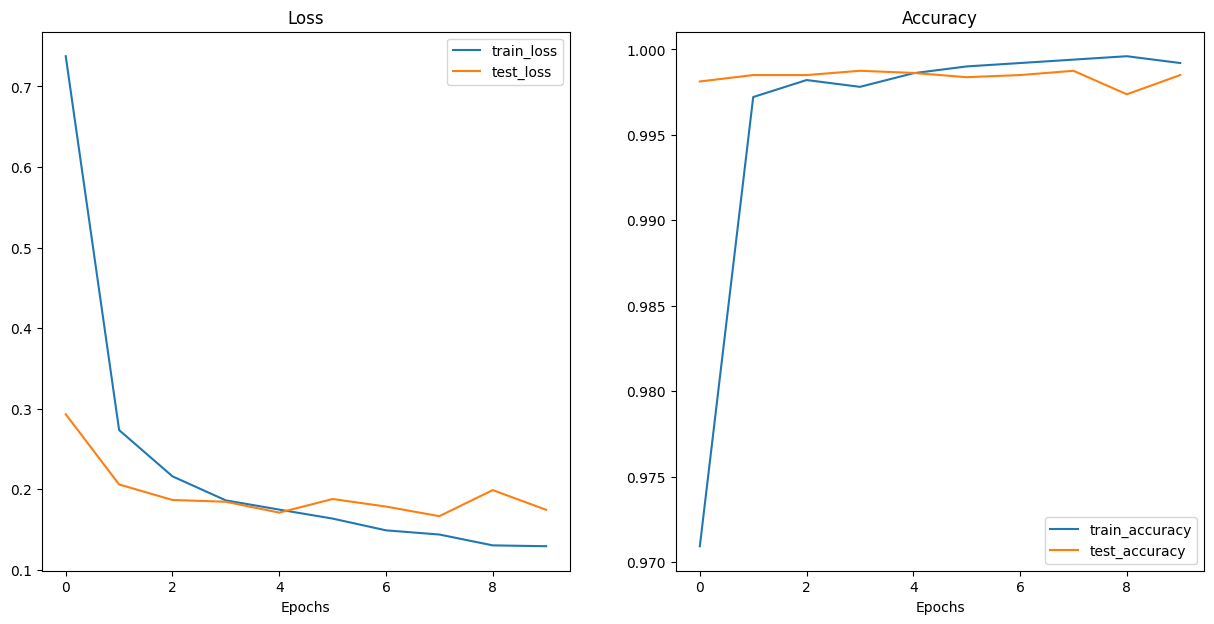


current exp / total: 2 / 4
NOTE:- The Accuracy is Top-5 Not Top-1 !!!
Training with: lr: 0.001, betas: (0.9, 0.999), eps: 1e-08, weight_decay: 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7736 | train_acc: 0.9689 | test_loss: 0.3065 | test_acc: 0.9980
Epoch: 2 | train_loss: 0.2988 | train_acc: 0.9970 | test_loss: 0.2315 | test_acc: 0.9982
Epoch: 3 | train_loss: 0.2392 | train_acc: 0.9976 | test_loss: 0.2028 | test_acc: 0.9981
Epoch: 4 | train_loss: 0.2126 | train_acc: 0.9982 | test_loss: 0.1902 | test_acc: 0.9988
Epoch: 5 | train_loss: 0.1827 | train_acc: 0.9996 | test_loss: 0.1950 | test_acc: 0.9980
Epoch: 6 | train_loss: 0.1665 | train_acc: 0.9998 | test_loss: 0.1851 | test_acc: 0.9988
Epoch: 7 | train_loss: 0.1576 | train_acc: 0.9994 | test_loss: 0.1798 | test_acc: 0.9985
Epoch: 8 | train_loss: 0.1578 | train_acc: 0.9984 | test_loss: 0.1739 | test_acc: 0.9982
Epoch: 9 | train_loss: 0.1456 | train_acc: 0.9988 | test_loss: 0.1750 | test_acc: 0.9982
Epoch: 10 | train_loss: 0.1293 | train_acc: 0.9996 | test_loss: 0.1791 | test_acc: 0.9985
total training time: 109.184 sec.
LOSS & Accuracy Curves
lr: 0.001, betas: (0.9, 0.999), eps: 1e-08, weight_d

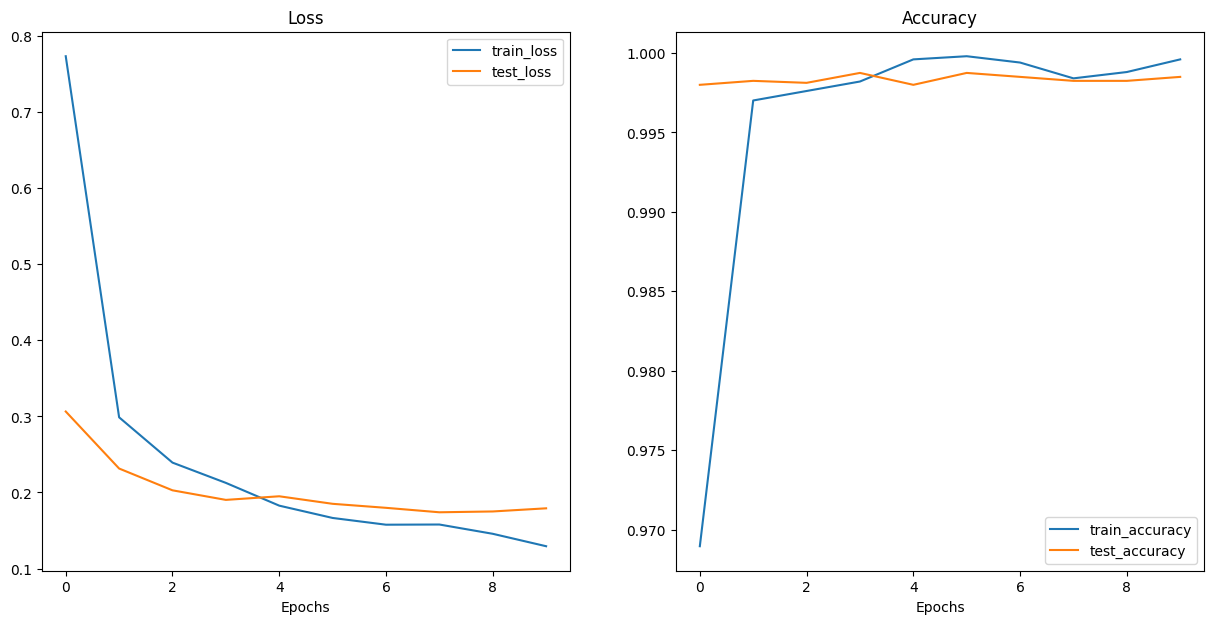


current exp / total: 3 / 4
NOTE:- The Accuracy is Top-5 Not Top-1 !!!
Training with: lr: 0.0001, betas: (0.8, 0.888), eps: 1e-08, weight_decay: 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9783 | train_acc: 0.7994 | test_loss: 1.4801 | test_acc: 0.9744
Epoch: 2 | train_loss: 1.2323 | train_acc: 0.9869 | test_loss: 0.9457 | test_acc: 0.9930
Epoch: 3 | train_loss: 0.8477 | train_acc: 0.9946 | test_loss: 0.6544 | test_acc: 0.9968
Epoch: 4 | train_loss: 0.6295 | train_acc: 0.9972 | test_loss: 0.5096 | test_acc: 0.9975
Epoch: 5 | train_loss: 0.5115 | train_acc: 0.9978 | test_loss: 0.4133 | test_acc: 0.9980
Epoch: 6 | train_loss: 0.4344 | train_acc: 0.9982 | test_loss: 0.3550 | test_acc: 0.9979
Epoch: 7 | train_loss: 0.3861 | train_acc: 0.9974 | test_loss: 0.3232 | test_acc: 0.9985
Epoch: 8 | train_loss: 0.3504 | train_acc: 0.9970 | test_loss: 0.2974 | test_acc: 0.9980
Epoch: 9 | train_loss: 0.3194 | train_acc: 0.9988 | test_loss: 0.2742 | test_acc: 0.9982
Epoch: 10 | train_loss: 0.3028 | train_acc: 0.9976 | test_loss: 0.2620 | test_acc: 0.9980
total training time: 110.351 sec.
LOSS & Accuracy Curves
lr: 0.0001, betas: (0.8, 0.888), eps: 1e-08, weight_

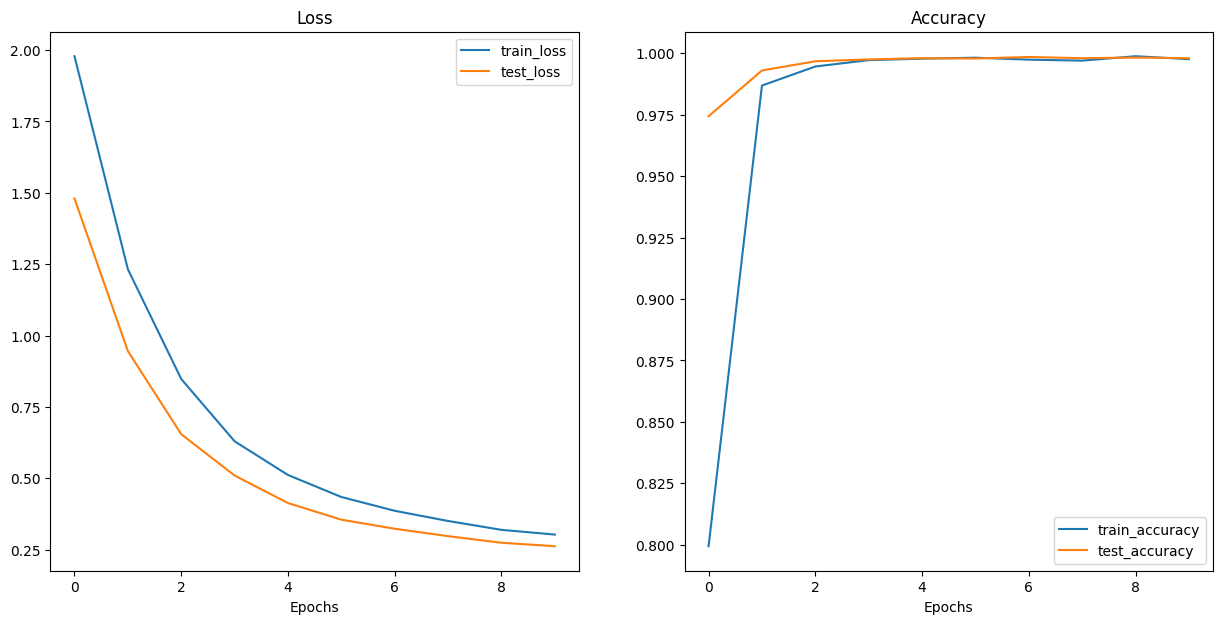


current exp / total: 4 / 4
NOTE:- The Accuracy is Top-5 Not Top-1 !!!
Training with: lr: 0.0001, betas: (0.9, 0.999), eps: 1e-08, weight_decay: 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9293 | train_acc: 0.8252 | test_loss: 1.4588 | test_acc: 0.9761
Epoch: 2 | train_loss: 1.2326 | train_acc: 0.9883 | test_loss: 0.9557 | test_acc: 0.9942
Epoch: 3 | train_loss: 0.8839 | train_acc: 0.9950 | test_loss: 0.7145 | test_acc: 0.9970
Epoch: 4 | train_loss: 0.6965 | train_acc: 0.9978 | test_loss: 0.5704 | test_acc: 0.9972
Epoch: 5 | train_loss: 0.5731 | train_acc: 0.9978 | test_loss: 0.4780 | test_acc: 0.9976
Epoch: 6 | train_loss: 0.4957 | train_acc: 0.9986 | test_loss: 0.4177 | test_acc: 0.9985
Epoch: 7 | train_loss: 0.4460 | train_acc: 0.9984 | test_loss: 0.3761 | test_acc: 0.9982
Epoch: 8 | train_loss: 0.3989 | train_acc: 0.9978 | test_loss: 0.3478 | test_acc: 0.9982
Epoch: 9 | train_loss: 0.3719 | train_acc: 0.9986 | test_loss: 0.3194 | test_acc: 0.9986
Epoch: 10 | train_loss: 0.3488 | train_acc: 0.9978 | test_loss: 0.3054 | test_acc: 0.9985
total training time: 110.485 sec.
LOSS & Accuracy Curves
lr: 0.0001, betas: (0.9, 0.999), eps: 1e-08, weight_

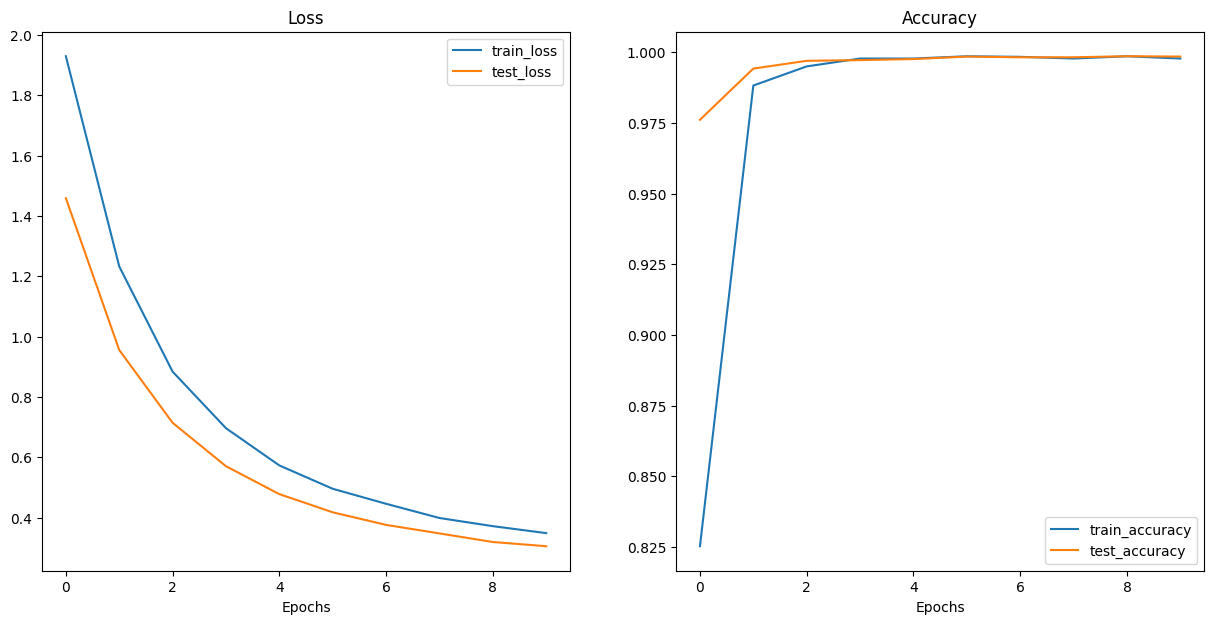

In [ ]:
cur,total = 1, len(lr)*len(betas)*len(eps)*len(weight_decay)
for h_parms in parms_combs:
  ### INIT MODEL STARTS ###
  # traning same model for each parms
  model_resnet = resnet18(weights=weights_resnet).to(device)

  # freeze all the layers resnet 
  for param in model_resnet.parameters():
      param.requires_grad = False
  num_ftrs = model_resnet.fc.in_features
  # only fc layer weights will be updated
  model_resnet.fc = nn.Linear(num_ftrs, 10).to(device) # 10 classes in STL

  ### INIT MODEL END ###

  optimizer = torch.optim.Adam(
      params=model_resnet.parameters(), lr=h_parms[0], betas=h_parms[1], eps=h_parms[2],weight_decay=h_parms[3]
  )

  # importing and init. the timer for checking model training time
  from timeit import default_timer as timer

  start_time = timer()
  print(f"current exp / total: {cur} / {total}")
  print(f"NOTE:- The Accuracy is Top-5 Not Top-1 !!!")
  print(f"Training with: lr: {h_parms[0]}, betas: {h_parms[1]}, eps: {h_parms[2]}, weight_decay: {h_parms[3]}")
  # train model
  model_resnet_results = train(
      model=model_resnet,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      acc_fn=acc_fn,
      epochs=NUM_EPOCHS,
  )

  # end timer
  end_time = timer()
  # printing time taken
  print(f"total training time: {end_time-start_time:.3f} sec.")
  # print("model stats:")
  # print(model_0_results)
  print(f"LOSS & Accuracy Curves\n"
        f"lr: {h_parms[0]}, betas: {h_parms[1]}, eps: {h_parms[2]}, weight_decay: {h_parms[3]}")
  plot_loss_curves(model_resnet_results)
  cur+=1
  print()

#### USING Optimizer RMSprop

In [ ]:
# Hyperparms
lr = [1e-2,1e-3] # learning rate
alpha = [0.88,0.99] # smoothing constant
momentum = [0.9] # momentum factor
eps = [1e-8] # term added to the denominator to improve numerical stability

parms_combs = [(l,a,m,e) for l in lr for a in alpha for m in momentum for e in eps]
# print(parms_combs)

# init. epochs
NUM_EPOCHS = 10

# init. loss function, accuracy function and optimizer
loss_fn = nn.CrossEntropyLoss()
acc_fn = Accuracy(task="multiclass", num_classes=10, top_k=5).to(device=device)


current exp / total: 1 / 4
NOTE:- The Accuracy is Top-5 Not Top-1 !!!
Training with: lr: 0.01, alpha: 0.88, momentum: 0.9, eps: 1e-08


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.0833 | train_acc: 0.9678 | test_loss: 1.9360 | test_acc: 0.9951
Epoch: 2 | train_loss: 2.6056 | train_acc: 0.9950 | test_loss: 2.0305 | test_acc: 0.9941
Epoch: 3 | train_loss: 2.6181 | train_acc: 0.9950 | test_loss: 2.2079 | test_acc: 0.9966
Epoch: 4 | train_loss: 2.1908 | train_acc: 0.9982 | test_loss: 3.5632 | test_acc: 0.9916
Epoch: 5 | train_loss: 2.1420 | train_acc: 0.9984 | test_loss: 2.7051 | test_acc: 0.9952
Epoch: 6 | train_loss: 2.6144 | train_acc: 0.9980 | test_loss: 4.6356 | test_acc: 0.9915
Epoch: 7 | train_loss: 2.5452 | train_acc: 0.9972 | test_loss: 3.9391 | test_acc: 0.9954
Epoch: 8 | train_loss: 2.8679 | train_acc: 0.9982 | test_loss: 3.4598 | test_acc: 0.9968
Epoch: 9 | train_loss: 2.2440 | train_acc: 0.9994 | test_loss: 3.8100 | test_acc: 0.9972
Epoch: 10 | train_loss: 1.9955 | train_acc: 0.9996 | test_loss: 4.1468 | test_acc: 0.9971
total training time: 110.863 sec.
LOSS & Accuracy Curves
Training with: lr: 0.01, alpha: 0.88, momentum: 0.9,

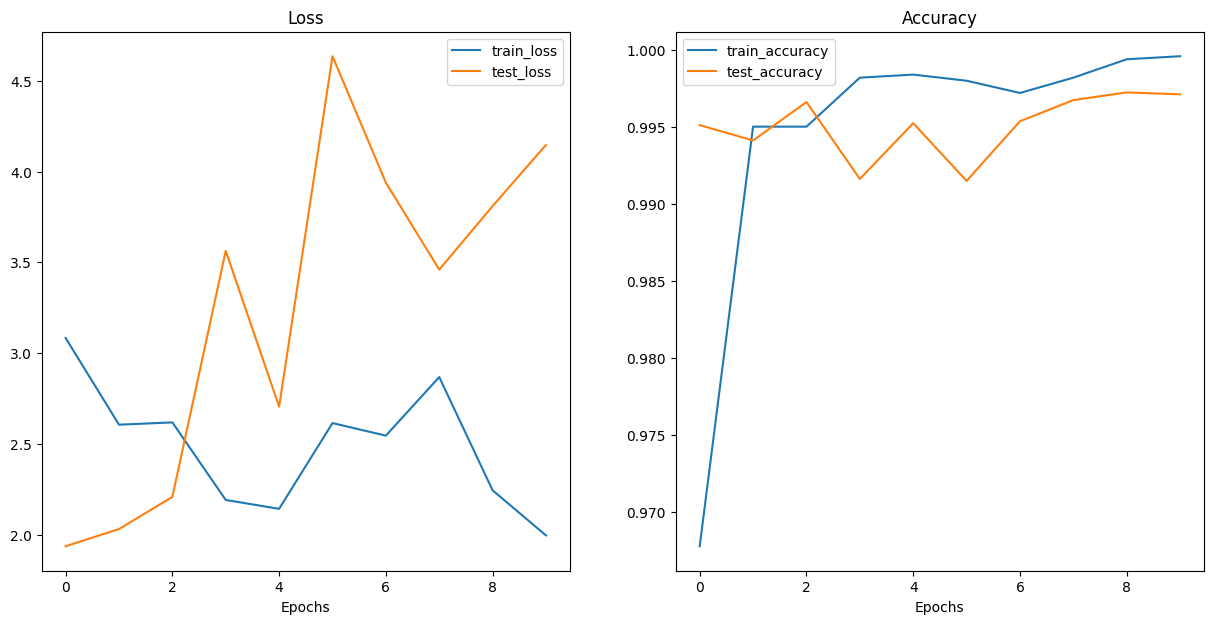


current exp / total: 2 / 4
NOTE:- The Accuracy is Top-5 Not Top-1 !!!
Training with: lr: 0.01, alpha: 0.99, momentum: 0.9, eps: 1e-08


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 7.5793 | train_acc: 0.9733 | test_loss: 2.6327 | test_acc: 0.9980
Epoch: 2 | train_loss: 3.3240 | train_acc: 0.9962 | test_loss: 4.8544 | test_acc: 0.9978
Epoch: 3 | train_loss: 2.6652 | train_acc: 0.9990 | test_loss: 2.7134 | test_acc: 0.9975
Epoch: 4 | train_loss: 2.5011 | train_acc: 0.9986 | test_loss: 4.6577 | test_acc: 0.9971
Epoch: 5 | train_loss: 2.8913 | train_acc: 0.9984 | test_loss: 4.8768 | test_acc: 0.9965
Epoch: 6 | train_loss: 2.7244 | train_acc: 0.9986 | test_loss: 3.7192 | test_acc: 0.9980
Epoch: 7 | train_loss: 2.6812 | train_acc: 0.9984 | test_loss: 5.4459 | test_acc: 0.9961
Epoch: 8 | train_loss: 2.5172 | train_acc: 1.0000 | test_loss: 4.5712 | test_acc: 0.9981
Epoch: 9 | train_loss: 2.7878 | train_acc: 0.9988 | test_loss: 4.7724 | test_acc: 0.9965
Epoch: 10 | train_loss: 2.5886 | train_acc: 0.9992 | test_loss: 7.8042 | test_acc: 0.9936
total training time: 110.895 sec.
LOSS & Accuracy Curves
Training with: lr: 0.01, alpha: 0.99, momentum: 0.9,

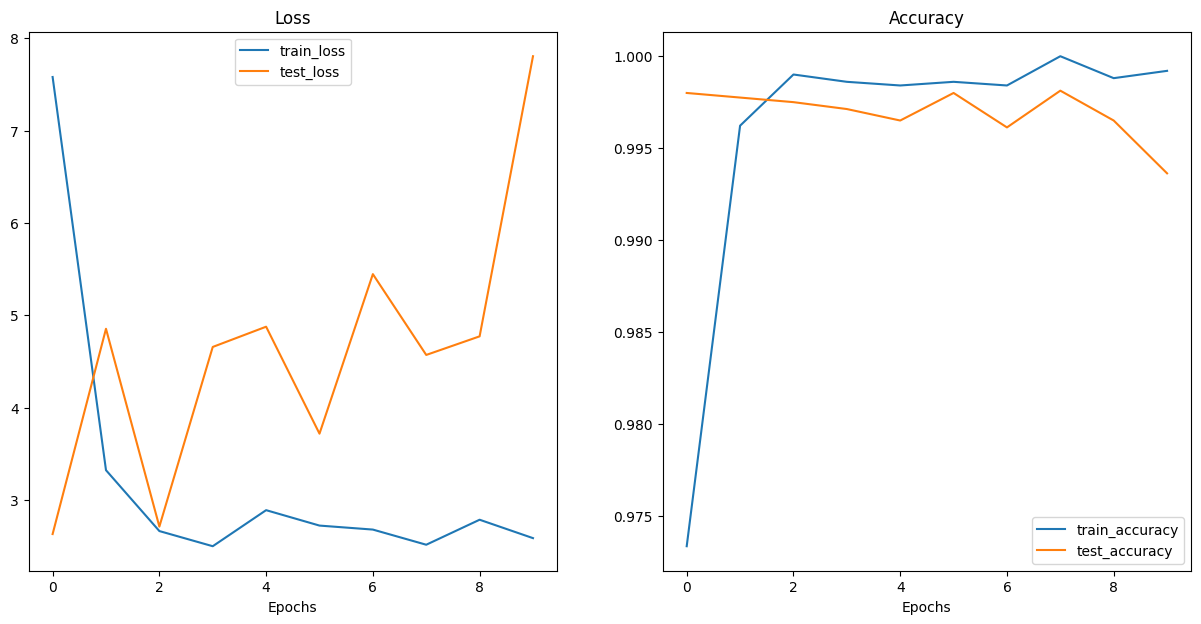


current exp / total: 3 / 4
NOTE:- The Accuracy is Top-5 Not Top-1 !!!
Training with: lr: 0.001, alpha: 0.88, momentum: 0.9, eps: 1e-08


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4450 | train_acc: 0.9837 | test_loss: 0.3337 | test_acc: 0.9968
Epoch: 2 | train_loss: 0.3052 | train_acc: 0.9976 | test_loss: 0.4862 | test_acc: 0.9916
Epoch: 3 | train_loss: 0.2661 | train_acc: 0.9990 | test_loss: 0.2928 | test_acc: 0.9980
Epoch: 4 | train_loss: 0.2537 | train_acc: 0.9982 | test_loss: 0.3158 | test_acc: 0.9966
Epoch: 5 | train_loss: 0.2258 | train_acc: 0.9976 | test_loss: 0.3902 | test_acc: 0.9971
Epoch: 6 | train_loss: 0.2378 | train_acc: 0.9988 | test_loss: 0.2924 | test_acc: 0.9979
Epoch: 7 | train_loss: 0.2107 | train_acc: 0.9992 | test_loss: 0.3593 | test_acc: 0.9971
Epoch: 8 | train_loss: 0.2012 | train_acc: 0.9992 | test_loss: 0.4363 | test_acc: 0.9965
Epoch: 9 | train_loss: 0.2204 | train_acc: 0.9996 | test_loss: 0.4912 | test_acc: 0.9960
Epoch: 10 | train_loss: 0.2002 | train_acc: 0.9996 | test_loss: 0.6135 | test_acc: 0.9951
total training time: 112.362 sec.
LOSS & Accuracy Curves
Training with: lr: 0.001, alpha: 0.88, momentum: 0.9

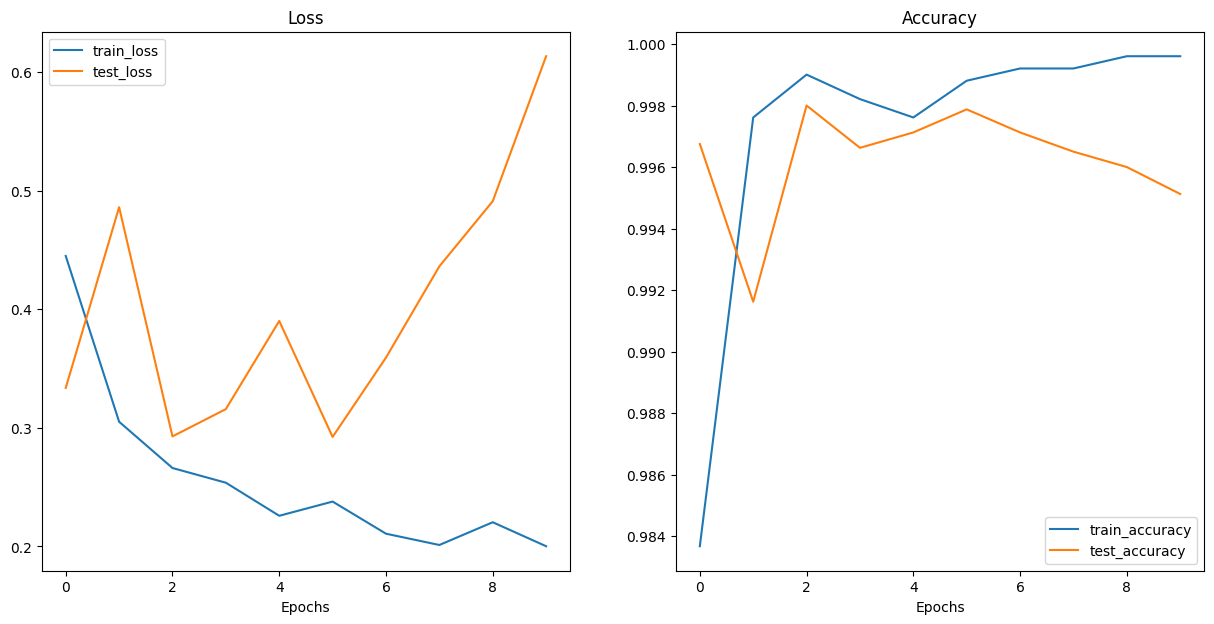


current exp / total: 4 / 4
NOTE:- The Accuracy is Top-5 Not Top-1 !!!
Training with: lr: 0.001, alpha: 0.99, momentum: 0.9, eps: 1e-08


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6505 | train_acc: 0.9795 | test_loss: 0.2898 | test_acc: 0.9970
Epoch: 2 | train_loss: 0.3276 | train_acc: 0.9974 | test_loss: 0.3035 | test_acc: 0.9976
Epoch: 3 | train_loss: 0.3660 | train_acc: 0.9976 | test_loss: 0.3070 | test_acc: 0.9975
Epoch: 4 | train_loss: 0.3230 | train_acc: 0.9992 | test_loss: 0.4113 | test_acc: 0.9974
Epoch: 5 | train_loss: 0.2846 | train_acc: 0.9988 | test_loss: 0.5358 | test_acc: 0.9960
Epoch: 6 | train_loss: 0.2281 | train_acc: 0.9994 | test_loss: 0.3881 | test_acc: 0.9981
Epoch: 7 | train_loss: 0.2203 | train_acc: 0.9990 | test_loss: 0.6991 | test_acc: 0.9942
Epoch: 8 | train_loss: 0.2474 | train_acc: 0.9994 | test_loss: 0.3615 | test_acc: 0.9982
Epoch: 9 | train_loss: 0.2075 | train_acc: 0.9990 | test_loss: 0.5087 | test_acc: 0.9975
Epoch: 10 | train_loss: 0.1842 | train_acc: 1.0000 | test_loss: 0.4072 | test_acc: 0.9974
total training time: 112.235 sec.
LOSS & Accuracy Curves
Training with: lr: 0.001, alpha: 0.99, momentum: 0.9

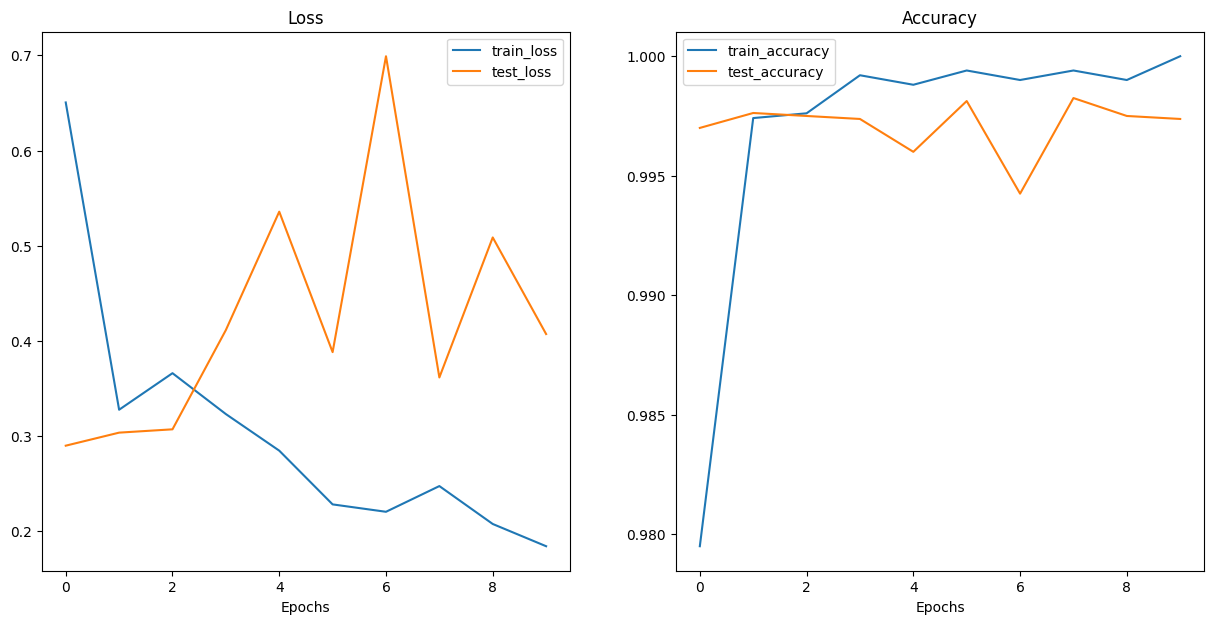

In [ ]:
cur,total = 1, len(lr)*len(alpha)*len(momentum)*len(eps)
for h_parms in parms_combs:
  ### INIT MODEL STARTS ###
  # traning same model for each parms
  model_resnet = resnet18(weights=weights_resnet).to(device)

  # freeze all the layers resnet 
  for param in model_resnet.parameters():
      param.requires_grad = False
  num_ftrs = model_resnet.fc.in_features
  # only fc layer weights will be updated
  model_resnet.fc = nn.Linear(num_ftrs, 10).to(device) # 10 classes in STL

  ### INIT MODEL END ###

  optimizer = torch.optim.RMSprop(
      params=model_resnet.parameters(), lr=h_parms[0], alpha=h_parms[1], momentum=h_parms[2], eps=h_parms[3]
  )

  # importing and init. the timer for checking model training time
  from timeit import default_timer as timer

  start_time = timer()
  print(f"current exp / total: {cur} / {total}")
  print(f"NOTE:- The Accuracy is Top-5 Not Top-1 !!!")
  print(f"Training with: lr: {h_parms[0]}, alpha: {h_parms[1]}, momentum: {h_parms[2]}, eps: {h_parms[3]}")
  # train model
  model_resnet_results = train(
      model=model_resnet,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      acc_fn=acc_fn,
      epochs=NUM_EPOCHS,
  )

  # end timer
  end_time = timer()
  # printing time taken
  print(f"total training time: {end_time-start_time:.3f} sec.")
  # print("model stats:")
  # print(model_0_results)
  print(f"LOSS & Accuracy Curves\n"
        f"Training with: lr: {h_parms[0]}, alpha: {h_parms[1]}, momentum: {h_parms[2]}, eps: {h_parms[3]}")
  plot_loss_curves(model_resnet_results)
  cur+=1
  print()

#### USING Optimizer Adadelta

In [ ]:
# Hyperparms
lr = [0.8,1] # learning rate
rho = [0.8,0.9] # coefficient used for computing a running average of squared gradients
eps = [1e-8] # term added to the denominator to improve numerical stability
weight_decay = [1e-3] # weight decay (L2 penalty)

parms_combs = [(l,r,e,w_d) for l in lr for r in rho for e in eps for w_d in weight_decay]
# print(parms_combs)

# init. epochs
NUM_EPOCHS = 10

# init. loss function, accuracy function and optimizer
loss_fn = nn.CrossEntropyLoss()
acc_fn = Accuracy(task="multiclass", num_classes=10, top_k=5).to(device=device)


current exp / total: 1 / 4
NOTE:- The Accuracy is Top-5 Not Top-1 !!!
Training with: lr: 0.8, rho: 0.8, eps: 1e-08, weight_decay: 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6226 | train_acc: 0.8873 | test_loss: 1.0064 | test_acc: 0.9935
Epoch: 2 | train_loss: 0.8113 | train_acc: 0.9930 | test_loss: 0.5727 | test_acc: 0.9978
Epoch: 3 | train_loss: 0.5293 | train_acc: 0.9980 | test_loss: 0.4133 | test_acc: 0.9985
Epoch: 4 | train_loss: 0.4171 | train_acc: 0.9978 | test_loss: 0.3401 | test_acc: 0.9986
Epoch: 5 | train_loss: 0.3580 | train_acc: 0.9974 | test_loss: 0.2985 | test_acc: 0.9984
Epoch: 6 | train_loss: 0.3115 | train_acc: 0.9976 | test_loss: 0.2660 | test_acc: 0.9986
Epoch: 7 | train_loss: 0.2857 | train_acc: 0.9978 | test_loss: 0.2498 | test_acc: 0.9986
Epoch: 8 | train_loss: 0.2606 | train_acc: 0.9982 | test_loss: 0.2360 | test_acc: 0.9986
Epoch: 9 | train_loss: 0.2511 | train_acc: 0.9990 | test_loss: 0.2214 | test_acc: 0.9988
Epoch: 10 | train_loss: 0.2396 | train_acc: 0.9982 | test_loss: 0.2143 | test_acc: 0.9986
total training time: 111.849 sec.
LOSS & Accuracy Curves
lr: 0.8, rho: 0.8, eps: 1e-08, weight_decay: 0.001


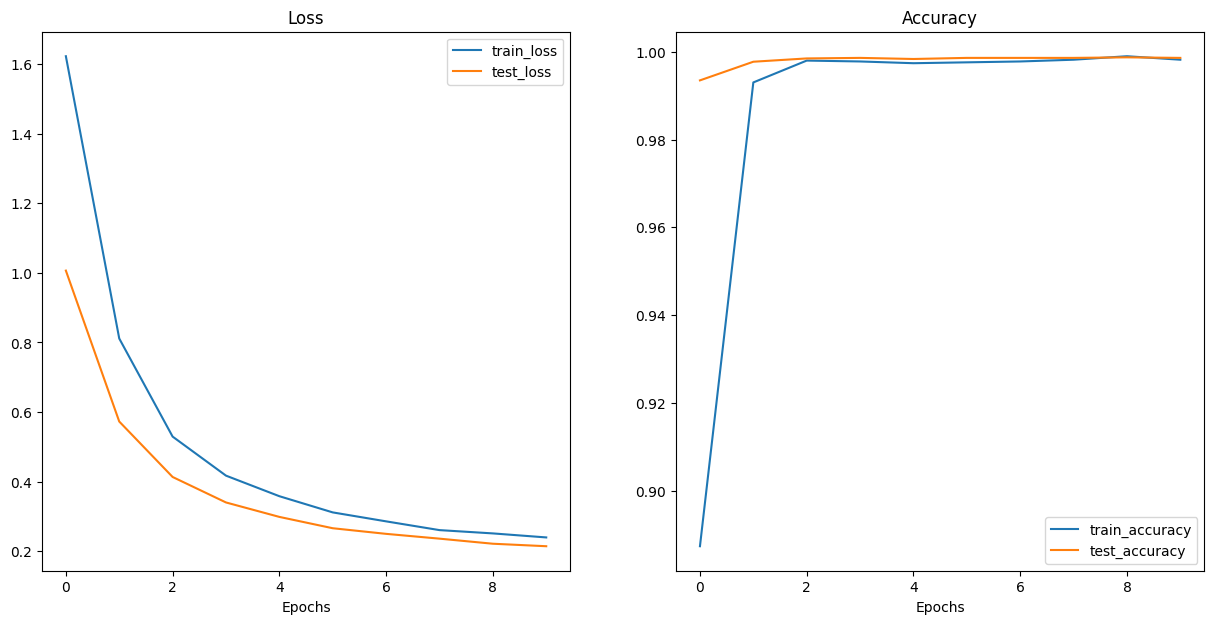


current exp / total: 2 / 4
NOTE:- The Accuracy is Top-5 Not Top-1 !!!
Training with: lr: 0.8, rho: 0.9, eps: 1e-08, weight_decay: 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.4946 | train_acc: 0.9262 | test_loss: 0.8775 | test_acc: 0.9962
Epoch: 2 | train_loss: 0.7166 | train_acc: 0.9950 | test_loss: 0.5074 | test_acc: 0.9979
Epoch: 3 | train_loss: 0.4784 | train_acc: 0.9966 | test_loss: 0.3679 | test_acc: 0.9984
Epoch: 4 | train_loss: 0.3813 | train_acc: 0.9968 | test_loss: 0.3050 | test_acc: 0.9988
Epoch: 5 | train_loss: 0.3190 | train_acc: 0.9976 | test_loss: 0.2702 | test_acc: 0.9982
Epoch: 6 | train_loss: 0.2859 | train_acc: 0.9976 | test_loss: 0.2479 | test_acc: 0.9989
Epoch: 7 | train_loss: 0.2656 | train_acc: 0.9980 | test_loss: 0.2307 | test_acc: 0.9986
Epoch: 8 | train_loss: 0.2464 | train_acc: 0.9980 | test_loss: 0.2207 | test_acc: 0.9986
Epoch: 9 | train_loss: 0.2373 | train_acc: 0.9984 | test_loss: 0.2141 | test_acc: 0.9989
Epoch: 10 | train_loss: 0.2261 | train_acc: 0.9982 | test_loss: 0.2056 | test_acc: 0.9989
total training time: 112.490 sec.
LOSS & Accuracy Curves
lr: 0.8, rho: 0.9, eps: 1e-08, weight_decay: 0.001


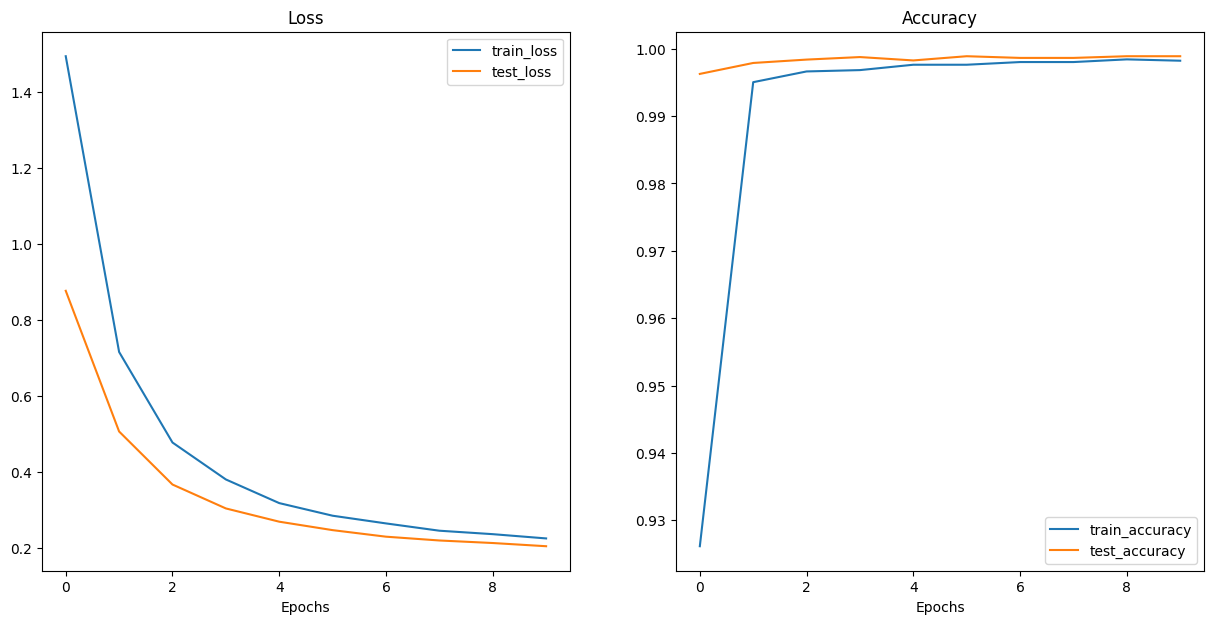


current exp / total: 3 / 4
NOTE:- The Accuracy is Top-5 Not Top-1 !!!
Training with: lr: 1, rho: 0.8, eps: 1e-08, weight_decay: 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.5172 | train_acc: 0.9118 | test_loss: 0.8830 | test_acc: 0.9959
Epoch: 2 | train_loss: 0.7093 | train_acc: 0.9960 | test_loss: 0.4877 | test_acc: 0.9984
Epoch: 3 | train_loss: 0.4624 | train_acc: 0.9964 | test_loss: 0.3542 | test_acc: 0.9988
Epoch: 4 | train_loss: 0.3625 | train_acc: 0.9980 | test_loss: 0.2960 | test_acc: 0.9990
Epoch: 5 | train_loss: 0.3116 | train_acc: 0.9974 | test_loss: 0.2603 | test_acc: 0.9989
Epoch: 6 | train_loss: 0.2821 | train_acc: 0.9984 | test_loss: 0.2383 | test_acc: 0.9990
Epoch: 7 | train_loss: 0.2589 | train_acc: 0.9986 | test_loss: 0.2329 | test_acc: 0.9986
Epoch: 8 | train_loss: 0.2460 | train_acc: 0.9978 | test_loss: 0.2202 | test_acc: 0.9991
Epoch: 9 | train_loss: 0.2298 | train_acc: 0.9990 | test_loss: 0.2051 | test_acc: 0.9986
Epoch: 10 | train_loss: 0.2252 | train_acc: 0.9984 | test_loss: 0.2002 | test_acc: 0.9989
total training time: 111.007 sec.
LOSS & Accuracy Curves
lr: 1, rho: 0.8, eps: 1e-08, weight_decay: 0.001


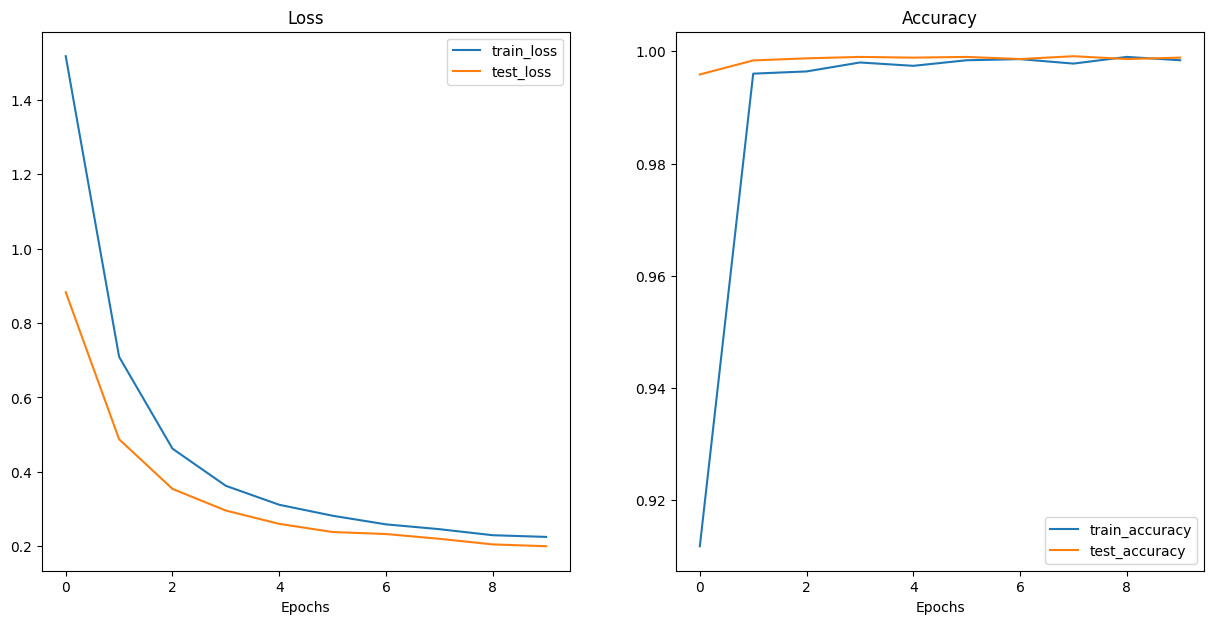


current exp / total: 4 / 4
NOTE:- The Accuracy is Top-5 Not Top-1 !!!
Training with: lr: 1, rho: 0.9, eps: 1e-08, weight_decay: 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.4410 | train_acc: 0.9090 | test_loss: 0.7630 | test_acc: 0.9958
Epoch: 2 | train_loss: 0.6187 | train_acc: 0.9964 | test_loss: 0.4358 | test_acc: 0.9981
Epoch: 3 | train_loss: 0.4095 | train_acc: 0.9978 | test_loss: 0.3275 | test_acc: 0.9985
Epoch: 4 | train_loss: 0.3338 | train_acc: 0.9976 | test_loss: 0.2788 | test_acc: 0.9984
Epoch: 5 | train_loss: 0.2884 | train_acc: 0.9982 | test_loss: 0.2478 | test_acc: 0.9985
Epoch: 6 | train_loss: 0.2620 | train_acc: 0.9974 | test_loss: 0.2337 | test_acc: 0.9988
Epoch: 7 | train_loss: 0.2417 | train_acc: 0.9986 | test_loss: 0.2201 | test_acc: 0.9985
Epoch: 8 | train_loss: 0.2226 | train_acc: 0.9982 | test_loss: 0.2071 | test_acc: 0.9984
Epoch: 9 | train_loss: 0.2087 | train_acc: 0.9984 | test_loss: 0.2023 | test_acc: 0.9988
Epoch: 10 | train_loss: 0.2079 | train_acc: 0.9978 | test_loss: 0.1975 | test_acc: 0.9984
total training time: 111.591 sec.
LOSS & Accuracy Curves
lr: 1, rho: 0.9, eps: 1e-08, weight_decay: 0.001


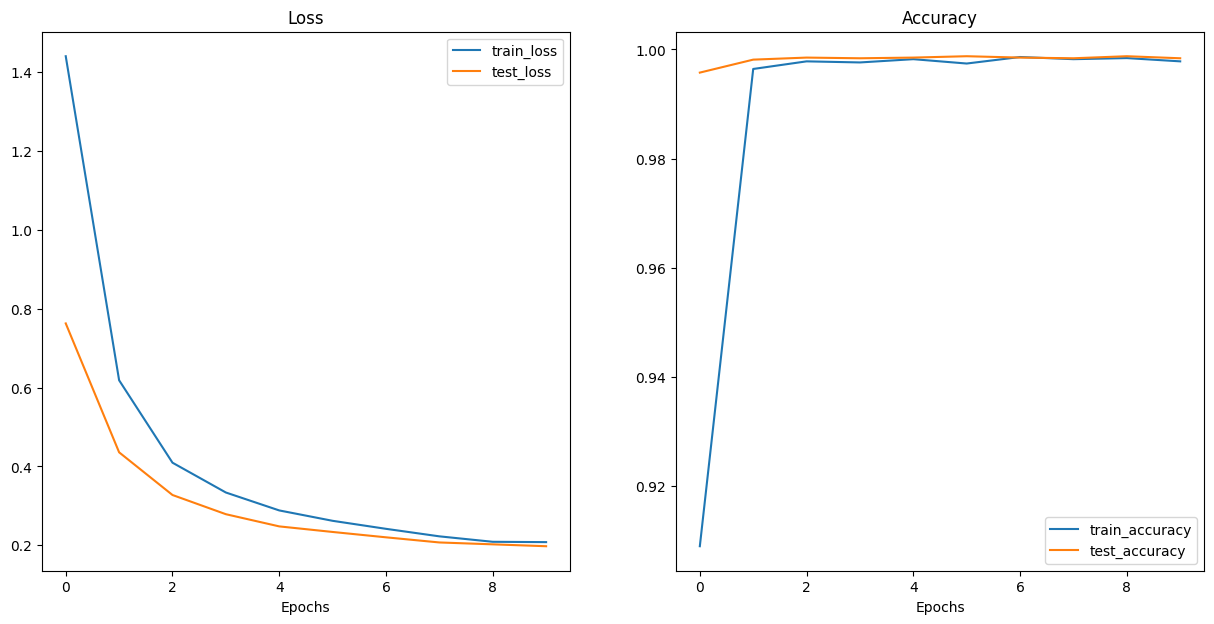

In [ ]:
cur,total = 1, len(lr)*len(rho)*len(eps)*len(momentum)
for h_parms in parms_combs:
  ### INIT MODEL STARTS ###
  # traning same model for each parms
  model_resnet = resnet18(weights=weights_resnet).to(device)

  # freeze all the layers resnet 
  for param in model_resnet.parameters():
      param.requires_grad = False
  num_ftrs = model_resnet.fc.in_features
  # only fc layer weights will be updated
  model_resnet.fc = nn.Linear(num_ftrs, 10).to(device) # 10 classes in STL

  ### INIT MODEL END ###

  optimizer = torch.optim.Adadelta(
      params=model_resnet.parameters(), lr=h_parms[0], rho=h_parms[1], eps=h_parms[2], weight_decay=h_parms[3]
  )

  # importing and init. the timer for checking model training time
  from timeit import default_timer as timer

  start_time = timer()
  print(f"current exp / total: {cur} / {total}")
  print(f"NOTE:- The Accuracy is Top-5 Not Top-1 !!!")
  print(f"Training with: lr: {h_parms[0]}, rho: {h_parms[1]}, eps: {h_parms[2]}, weight_decay: {h_parms[3]}")
  # train model
  model_resnet_results = train(
      model=model_resnet,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      acc_fn=acc_fn,
      epochs=NUM_EPOCHS,
  )

  # end timer
  end_time = timer()
  # printing time taken
  print(f"total training time: {end_time-start_time:.3f} sec.")
  # print("model stats:")
  # print(model_0_results)
  print(f"LOSS & Accuracy Curves\n"
        f"lr: {h_parms[0]}, rho: {h_parms[1]}, eps: {h_parms[2]}, weight_decay: {h_parms[3]}")
  plot_loss_curves(model_resnet_results)
  cur+=1
  print()